# Import the data

Right now doing some 'cleaning' to help with the join scores, but eventually I think I'll just have a better join score...

In [3]:
import string

def simple_tokenize(s):
    """where s is a string of text, raw poem"""
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s.split(" ")

stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stopwords = ["the", "a", "an"]

def remove_stop_words(w):
    """where w is a list of lowercase words w no punctuation"""
    a = []
    for word in w:
        if word not in stopwords:
            a.append(word)
    return a

raw_data = []
data = []
with open("part_a.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1]
            raw_data.append(text)
            w = simple_tokenize(text.strip())
            data.append(remove_stop_words(w))

(' ').join(data[0]), (' ').join(data[1])

('i visualize two paths my life might take one where i have child and one where i do not i try to place them on equal footing imagining each as something i truly want though i know both will be filled with disappointment and loss',
 'to push away disappointment i prepare for “worst” i say all time to s when we discuss what our life might look like in future “though maybe i’m infertile” it’s not exactly superstition i just don’t want to be surprised by my sadness i want to see it plain')

# Calculate transition scores

i.e. How well one poem flows into another. This will be improved!

In [4]:
def join_score(a, b, n=10):
    """where a and b are lists of lowercase words, and n is num of words to consider"""
    a_set = set(a[-n:])
    b_set = set(b[:n])
    return n - len(a_set.intersection(b_set))

test = ("one way here dog why".split(" "), "one dog ready set go".split(" "))

join_score(data[0], data[1]), join_score(test[0], test[1])    

(8, 8)

In [5]:
import numpy as np

def calc_all_scores(data, join_score_func):
    scores = np.empty([len(data), len(data)])
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                s = np.nan
            else:
                s = join_score_func(data[i], data[j])
            scores[i][j] = s
    return scores

In [6]:
scores = calc_all_scores(data, join_score)

In [7]:
scores

array([[nan,  8.,  8., ...,  9.,  8.,  9.],
       [ 8., nan,  9., ...,  8.,  9.,  9.],
       [10.,  9., nan, ...,  8., 10., 10.],
       ...,
       [ 9., 10., 10., ..., nan, 10., 10.],
       [ 9.,  8.,  9., ...,  8., nan,  9.],
       [ 8.,  8.,  9., ...,  8.,  9., nan]])

# Get poems that fit together best

This is just to check that the join scores are working okay.

In [8]:
def get_top_scores(scores, thisdata, asc=True, n=5):
    flattened = scores.flatten()
    if asc:
        sorted_indices = np.argsort(flattened)
    else:
        sorted_indices = np.argsort(-flattened)
    indices_2d = np.unravel_index(sorted_indices, scores.shape)
    sorted_indices_list = list(zip(indices_2d[0], indices_2d[1]))
    
    for i, val in enumerate(sorted_indices_list[0:n]):
        print('indices:', val)
        print('score:', scores[val[0],val[1]])
        print('>>>', raw_data[val[0]], '\n>>>>', raw_data[val[1]], '\n')

    return sorted_indices_list

In [9]:
x = get_top_scores(scores, data, asc=True, n=10)

indices: (15, 163)
score: 5.0
>>>  We get our dog neutered. He comes home whimpering in the back of the car, then struggles to lie down in the bedroom, his back leg twitching, his head drooping. With the cone he is unable to push his head into my stomach, like he normally does in the morning when he's just woken up. Instead he stands sadly still, tail down. Eventually, he curls up the best he can. We take turns laying down next to him while he sleeps in fits. We were not sure that we should neuter him, but we decided to do it. Reasons, reasons. Fertility is not his future.
 
>>>>  It is not my job to imagine the future. 
 

indices: (96, 48)
score: 5.0
>>>  I am on the verge of tears. The edge of crying. I look over the precipice and it is no good out there, I'd like to stay here, where the emotions live behind the eyes, where I'm still able to walk to work and make myself dinner. I am overflowing. With what? With a lack of breath, with a fear of the future, with a desire to stay home,

# Find 'best' path

This is a traveling salesman problem with assymetric distances. I'm going to use a Markov Chain Monte Carlo method to stochastically find a good path. The basic idea is to start with a random path, and then randomly swap "cities" and check if the new path is better; then we repeat this many times. However, to avoid local minimums, we add some wiggle room for selecting a slightly less optimal path. We'll add in simulated annealing, which means we'll decrease the wiggle room as we go on.

To keep in line with traveling salesman terminology, each poem is called 'city', and the ordering of the poems is called the 'tour'. The scores between poems are 'distances'.

Shouldn't take more than a second or two to run with 50k iterations.

In [10]:
import random
import math

def calculate_total_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))

def swap_cities(tour):
    new_tour = tour[:]
    i, j = random.sample(range(len(tour)), 2)
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def simulated_annealing_tsp(cities, distance_matrix, iterations, initial_temperature):
    current_tour = random.sample(cities, len(cities))
    current_distance = calculate_total_distance(current_tour, distance_matrix)
    best_tour = current_tour
    best_distance = current_distance

    temperature = initial_temperature

    down_sample = 100
    distance_array = np.empty(int(iterations/down_sample))

    for iteration in range(iterations):
        if iteration%down_sample == 0:
            distance_array[int(iteration/down_sample)] = current_distance
            
        new_tour = swap_cities(current_tour)
        new_distance = calculate_total_distance(new_tour, distance_matrix)
        delta_distance = new_distance - current_distance

        if delta_distance < 0 or random.random() < math.exp(-delta_distance / temperature):
            # print("new distance:", new_distance)
            current_tour = new_tour
            current_distance = new_distance
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        temperature *= 0.999  # Cooling schedule

    return best_tour, best_distance, distance_array

# Example usage
cities = list(range(len(data)))  # Example cities
distance_matrix = scores  # Your asymmetric distance matrix
iterations = 50000
initial_temperature = 100

best_tour, best_distance, distance_array = simulated_annealing_tsp(cities, distance_matrix, iterations, initial_temperature)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)


Best Tour: [21, 135, 144, 58, 103, 35, 2, 13, 106, 57, 125, 104, 154, 50, 148, 113, 4, 146, 20, 71, 83, 69, 34, 51, 76, 141, 70, 49, 167, 117, 17, 52, 136, 12, 110, 42, 122, 63, 162, 82, 74, 68, 37, 158, 43, 133, 101, 3, 89, 79, 47, 137, 107, 44, 97, 115, 109, 40, 164, 95, 23, 147, 131, 72, 142, 19, 96, 48, 7, 108, 159, 33, 6, 65, 123, 36, 128, 153, 114, 56, 16, 140, 46, 24, 151, 121, 88, 31, 118, 27, 102, 30, 161, 80, 87, 130, 91, 92, 100, 143, 39, 0, 99, 85, 15, 163, 32, 60, 55, 41, 90, 126, 156, 28, 157, 111, 78, 26, 11, 155, 127, 67, 1, 94, 86, 54, 124, 116, 138, 149, 18, 120, 134, 61, 14, 5, 166, 165, 9, 53, 77, 150, 38, 98, 132, 10, 129, 119, 145, 8, 25, 93, 62, 22, 81, 152, 160, 105, 75, 29, 139, 84, 73, 64, 59, 45, 112, 66]
Best Distance: 1339.0


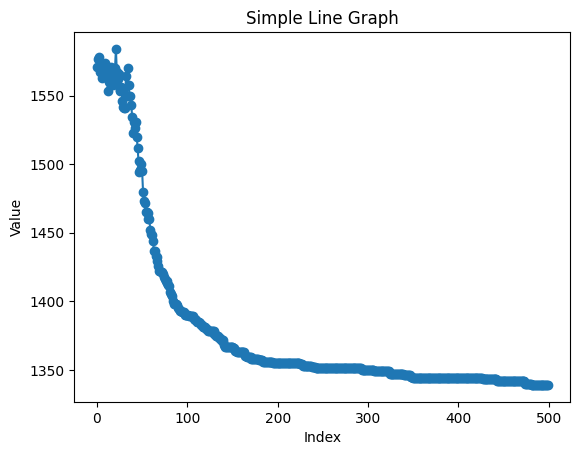

In [11]:
import matplotlib.pyplot as plt

# Generate x-axis values (indices of the array)
indices = np.arange(len(distance_array))

# Create a line plot
plt.plot(indices, distance_array, marker='o')

# Add titles and labels
plt.title('Simple Line Graph')
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()


In [15]:
with open('best_tour.txt', 'w') as fle:
    for i, index in enumerate(best_tour[:-1]):
        poem = raw_data[index]
        score = scores[index, best_tour[i+1]]
        fle.write(f"{poem} [{score}]")